# EMRISur1dq1e4

Notebook Author: Tousif Islam (tislam@umassd.edu)

The waveform model, EMRISur1dq1e4, is described in https://arxiv.org/abs/1910.10473 (Nur E. M. 2019 et. al.). 

EMRISur1dq1e4 is a surrogate gravitational-waveform model for non-spinning black hole binary systems with mass-ratios varying from 3 to $10^4$. This surrogate model is trained on waveform data generated by point-particle black hole perturbation theory (ppBHPT), with the total mass rescaling paramter tuned to NR simulations according to the paper's Eq. 4. Available modes are  $\{(2,2), (2,1), (3,3), (3,2), (3,1), (4,4), (4,3), (4,2), (5,5), (5,4), (5,3)\}$. The $m<0$ modes can be deduced from the m>0 modes due to symmetry of the system about the orbital plane. 

NOTE : This notebook rquires the file emri_sur_load.py and EMRISur1dq1e4.h5 datafile in the same directory for waveform generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emri_sur_load as emriSur
import scipy
from scipy.interpolate import InterpolatedUnivariateSpline as Spline
from scipy.interpolate import splrep, splev

# Evaluation example

Input: mass ratio q, and (optionally) modes to generate = [(2,1),(2,2),(3,1),(3,2),(3,3),(4,2),(4,3),(4,4),(5,3),(5,4),(5,5)]

Output: dictionary of modes with surrogate waveform

Both h and t are in geometric units

In [2]:
from gwtools.harmonics import sYlm


q = 10000.0 # mass ratio
timey, h_out = emriSur.generate_surrogate(q) #h_out is a dictionary with modes as key; defaults to all avail modes

/home/ahnitz/projects/hmr/env/lib/python2.7/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home/ahnitz/projects/hmr/env/lib/python2.7/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


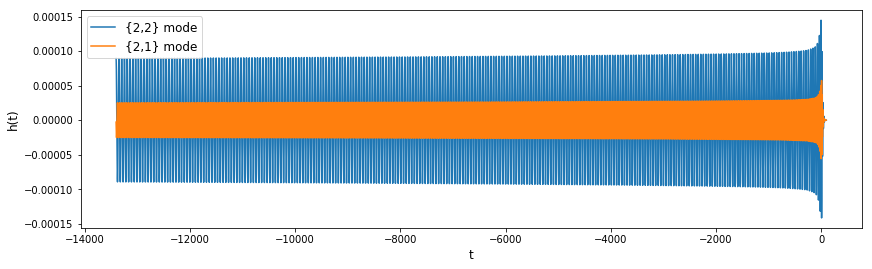

In [3]:
h_22=h_out[(2,2)]
h_21=h_out[(3,3)]

plt.figure(figsize=(14,4))
plt.plot(timey,np.real(h_22),label='{2,2} mode')
plt.plot(timey,np.real(h_21),label='{2,1} mode')
plt.xlabel('t',fontsize=12)
plt.ylabel('h(t)',fontsize=12)
plt.legend(fontsize=12)
#plt.savefig('emri_sur_q_%f.png'%q)
plt.show()

# Evaluation example : Physical Waveforms

Scales the waveform obtained in geometrc unit to physical units

The example below is shown for 22 mode only.

Input: total mass M (in Solar Mass unit), luminosity distance dL (Mpc)

In [4]:
from pycbc.types import TimeSeries
G=6.674*1e-11
MSUN_SI = 1.9885469549614615e+30
PC_SI = 3.085677581491367e+16
C_SI = 299792458.0

def mode_sum(h_modes, theta, phi, fake_neg_modes=True):
    """ Sums over h_modes at a given theta, phi.
        If fake_neg_modes = True, deduces m<0 modes from m>0 modes.
        If fake_neg_modes = True, m<0 modes should not be in h_modes.
    """
    h = 0.
    for (ell, m), h_mode in h_modes.items(): # inefficient in py2
        if ell !=2 and m !=2:
            continue        
        print ell, m
        h += sYlm(-2, ell, m, theta, phi) * h_mode
        if fake_neg_modes:
            if m > 0:
                h += sYlm(-2, ell, -m, theta, phi) \
                    * (-1)**ell * h_mode.conjugate()
            elif m < 0:
                # Looks like this m<0 mode exits, we should be using that.
                raise Exception('Expected only m>0 modes.')
    return h

def genemri(mass1, mass2, inclination=0, polarization=0, distance=1.0):
    q = max(mass1 / mass2, mass2/mass2) # mass ratio
    timey, h_out = emriSur.generate_surrogate(q)
    h = mode_sum(h_out, inclination, polarization)
    mtotal = mass1 + mass2
    # values of M and dL
    M = mtotal * MSUN_SI
    dL = 1.0* PC_SI * distance
    # scaling of time and h(t)
    time = timey * ( G * M / C_SI ** 3.0)
    ht = (h * (G * M / C_SI ** 3.0) / dL)
    hp = TimeSeries(ht.real, epoch=float(time[0]), delta_t=time[1]-time[0])
    hc = TimeSeries(ht.imag, epoch=float(time[0]), delta_t=time[1]-time[0])
    return hp, hc

In [5]:
import numpy
hp, hc = genemri(1.0, 10.0, inclination = 0)

pylab.figure(figsize=[15, 3])
pylab.plot(hp.sample_times, hp)

3 2
2 1
2 2
4 2


NameError: name 'pylab' is not defined

In [ ]:
from pycbc.waveform import get_td_waveform

pylab.figure(figsize=[15, 3])
hp, hc = get_td_waveform(approximant="EOBNRv2", mass1=1, mass2=10, f_lower=140, delta_t=1.0/4096)
pylab.plot(hp.sample_times, hp)